# Modèles de machine learning classification

## Objectifs de ce notebook

Dans ce notebook, nous allons tester différents modèles de machine learning pour la prédiction des seuils de promotion:

**Prédiction des classes de délais depuis la date de sortie avant réduction (33%)**

Comparaison des performances de plusieurs modèles
- **Random forest**
- **XGBoost**

## Données utilisées

Utilisation du fichier nettoyé dataset jeux ps5 avec travail sur les features réalisé: **featured_games_dataset_final.csv**.

- modélisation avec les données de bases
- modélisation avec les données après feature engineering

## Note sur les librairies utilisées

Ce notebook utilise scikit learn pour la partie machine learning

## Import des librairies

In [760]:
# Python base
import sys
from pathlib import Path
import os

# Bibliothèques principales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder,OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.metrics import mean_absolute_error, r2_score, root_mean_squared_error,accuracy_score
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LogisticRegression, RidgeClassifier, SGDClassifier
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    AdaBoostClassifier,
    ExtraTreesClassifier,
    HistGradientBoostingClassifier,
    BaggingClassifier,
)
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier


from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold

import warnings
warnings.filterwarnings('ignore')

## Méthodes utiles

In [761]:
def column_summary(df: pd.DataFrame):
    summary = []
    for col in df.columns:
        col_type = df[col].dtype
        non_null = df[col].notna().sum()
        null_count = df[col].isna().sum()
        
        # Gérer le cas où la colonne contient des listes (unhashable)
        try:
            unique_count = df[col].nunique()
        except TypeError:
            # Si erreur (listes), convertir en string temporairement
            unique_count = df[col].astype(str).nunique()
            print(f"⚠️ Colonne '{col}' contient des types non-hashable (probablement des listes)")

        summary.append({
            'Column': col,
            'Type': str(col_type),
            'Non-Null Count': non_null,
            'Null Count': null_count,
            'Unique Values': unique_count,
        })

    # Afficher le résumé des colonnes
    print("=" * 80)
    print("Résumé détaillé des colonnes:")
    print("=" * 80)
    column_summary_df = pd.DataFrame(summary)
    print(column_summary_df.to_string(index=False))
    print("\n")

In [762]:
class OutlierClipper(BaseEstimator, TransformerMixin):
    """Clip les outliers avec la méthode IQR"""
    
    def __init__(self):
        self.lower_bounds_ = None
        self.upper_bounds_ = None
    
    def fit(self, X, y=None):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
        else:
            X_values = X
        
        Q1 = np.percentile(X_values, 25, axis=0)
        Q3 = np.percentile(X_values, 75, axis=0)
        IQR = Q3 - Q1
        
        self.lower_bounds_ = Q1 - 1.5 * IQR
        self.upper_bounds_ = Q3 + 1.5 * IQR
        
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            X_values = X.values
            X_clipped = np.clip(X_values, self.lower_bounds_, self.upper_bounds_)
            return pd.DataFrame(X_clipped, columns=X.columns, index=X.index)
        else:
            return np.clip(X, self.lower_bounds_, self.upper_bounds_)
        
    def get_feature_names_out(self, input_features=None):
        """Retourne les noms des features (inchangés)"""
        return input_features

In [763]:
class ZeroImputer(BaseEstimator, TransformerMixin):
    """Impute les valeurs manquantes par 0"""
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if isinstance(X, pd.DataFrame):
            return X.fillna(0)
        else:
            # Si numpy array
            X_copy = X.copy()
            X_copy[np.isnan(X_copy)] = 0
            return X_copy
        
    def get_feature_names_out(self, input_features=None):
        """Retourne les noms des features (inchangés)"""
        return input_features

## Chargement des données

In [764]:
path = os.path.join(Path.cwd().parent, "data/processed")

In [765]:
# Charger les données CSV pour verifier
df_dataset = pd.read_csv(os.path.join(path, "featured_games_dataset_final.csv"))

In [766]:
column_summary(df_dataset)

Résumé détaillé des colonnes:
                                 Column    Type  Non-Null Count  Null Count  Unique Values
                               id_store  object            5382           0           5382
                  pssstore_stars_rating float64            5382           0            352
            pssstore_stars_rating_count   int64            5382           0           1583
                metacritic_critic_score float64            1268        4114             67
                                 is_ps4   int64            5382           0              2
                               is_indie   int64            5382           0              2
                                 is_dlc   int64            5382           0              1
                                  is_vr   int64            5382           0              2
                        is_opti_ps5_pro   int64            5382           0              2
                            is_remaster   int64            5

In [767]:
df_dataset.head()

,id_store,pssstore_stars_rating,pssstore_stars_rating_count,metacritic_critic_score,is_ps4,is_indie,is_dlc,is_vr,is_opti_ps5_pro,is_remaster,...,sub_languages_count,content_score,content_category,exclusif_playstation_content,visibility_score,visibility_category,pegi_unified,price_category,game_age_years,release_season
0,EP8311-PPSA19174_00-0421646910657705,1.57,14,NaN,0,0,0,0,0,0,...,NaN,9.0,minimal,0,7.0,obscure,7,0 - 7.99,2,fall
1,EP2005-PPSA06055_00-SINUCA0000000000,3.26,72,NaN,0,0,0,0,0,0,...,NaN,3.0,minimal,0,43.0,moderate,3,0 - 7.99,3,spring
2,EP8311-PPSA16513_00-0233078860249892,1.55,11,NaN,0,0,0,0,0,0,...,NaN,9.0,minimal,0,7.0,obscure,3,0 - 7.99,2,spring
3,EP8311-PPSA13840_00-0277389480637871,1.44,18,NaN,0,0,0,0,0,0,...,NaN,9.0,minimal,0,8.0,obscure,3,0 - 7.99,2,winter
4,EP8311-PPSA12662_00-0212989199890961,1.17,23,NaN,0,0,0,0,0,0,...,NaN,9.0,minimal,0,8.0,obscure,3,0 - 7.99,3,winter


## Rappel des features disponibles

In [768]:
# 47 features au total

# X Basic features simple sans traitement avancés (28)

# base_price                    - numeric (float)
# pssstore_stars_rating_count   - numeric (int)
# pssstore_stars_rating         - numeric (float)
# is_indie                      - boolean
# has_microtransactions         - boolean
# dlcs_count                        - numeric (int)
# packs_deluxe_count            - numeric (int)
# series_count                   - numeric (int)
# trophies_count                - numeric (int)
# is_vr                         - boolean
# has_local_multiplayer         - boolean
# has_online_multiplayer        - boolean
# is_online_only                - boolean
# is_opti_ps5_pro               - boolean
# is_ps_exclusive               - boolean
# difficulty                    - numeric (int)
# is_remaster                   - boolean
# is_ps4                        - boolean
# pegi_unified                  - category (numeric)
# metacritic_critic_score       - numeric (float)
# hours_main_story              - numeric (float)
# voice_languages_count        - numeric (int)
# sub_languages_count           - numeric (int)
# download_size_gb              - numeric (float)
# price_category                - category



#  X Advanced features engineered (19)

# popularity_score              - numeric (float)
# popularity_category           - category
# visibility_score              - numeric (float)
# visibility_category           - category
# exclusif_playstation_content  - boolean
# publisher_game_count          - numeric (int)
# publisher_game_count_cat      - category
# publisher_category            - category
# genre_action_aventure         - boolean
# genre_roles                   - boolean
# genre_sports                  - boolean
# genre_reflexion               - boolean
# genre_rapide                  - boolean
# localization_category         - category
# download_size_category        - category
# content_score                 - numeric (float)
# content_category              - category
# game_age_years                - numeric (int)
# month_sin                     - numeric (float)
# month_cos                     - numeric (float)
# release_season                - category


#  X Bonus observations à + 60 jours (2)

# has_5pct_discount_at_30d      - boolean
# has_10pct_discount_at_60d     - boolean

# Y
# 
# Regression nombre de jours
# 
# days_to_10_percent_discount - numeric (int)
# days_to_25_percent_discount - numeric (int)
# days_to_33_percent_discount - numeric (int)
# days_to_50_percent_discount - numeric (int)
# days_to_75_percent_discount - numeric (int)

# Classification tranche délais avant promotion

# Classification binaires:

# has_33_percent_discount_before_0.6_year
# has_50_percent_discount_before_1_year
# has_75_percent_discount_before_3_year
# 
# Classification multiples:

# days_to_10_percent_discount_category - category
# days_to_25_percent_discount_category - category
# days_to_33_percent_discount_category - category
# days_to_50_percent_discount_category - category
# days_to_75_percent_discount_category - category

## Combinaison de features

In [769]:
# Feature de base sans feature engeniering avancés
base_features = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "dlcs_count",
        "release_month",
        # "game_age_years",
    ],
    "numeric_discrete_median": [
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
}

# Feature de base sans feature engeniering avancés + données disponible + 60j après sortie
base_features_post_release = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
        "pssstore_stars_rating",  # Observation post sortie
        "metacritic_critic_score",  # Observation post sortie
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "dlcs_count",
        "release_month",
        # "game_age_years",
    ],
    "numeric_discrete_median": [
        "trophies_count",
        "pssstore_stars_rating_count",  # Observation post sortie
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
        "has_5pct_discount_at_30d",  # Observation post sortie
        "has_10pct_discount_at_60d",  # Observation post sortie
    ],
    "categorical_cols": [
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
}

# Feature de base + Feature engeniering avancés
all_features = {
    "numeric_continuous": [
        "base_price",
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "publisher_game_count",
        "dlcs_count",
        "release_month",
        # "game_age_years",
    ],
    "numeric_discrete_median": [
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "exclusif_playstation_content", #advanced
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "price_category",
        "publisher_category",
        "visibility_category", # advanced
        "content_category", # advanced
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat",
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "score_cols": ["visibility_score", "content_score"], #advanced
}

# Feature de base + Feature engeniering avancés + données disponible 60j après sortie
all_features_post_release = {
    "numeric_continuous": [
        "base_price",
        "pssstore_stars_rating",  # Observation post sortie
        "metacritic_critic_score",  # Observation post sortie
        "hours_main_story",
        "download_size_gb",
    ],
    "numeric_discrete_zero": [
        "packs_deluxe_count",
        "series_count",
        "sub_languages_count",
        "voice_languages_count",
        "publisher_game_count",
        "dlcs_count",
        "release_month",
        # "game_age_years",
    ],
    "numeric_discrete_median": [
        "pssstore_stars_rating_count",  # Observation post sortie
        "trophies_count",
    ],
    "boolean_cols": [
        "is_indie",
        "is_vr",
        "is_ps_exclusive",
        "is_remaster",
        "is_ps4",
        "has_local_multiplayer",
        "has_online_multiplayer",
        "is_online_only",
        "has_microtransactions",
        "is_opti_ps5_pro",
        "exclusif_playstation_content", #advanced
        "has_5pct_discount_at_30d",  # Observation post sortie
        "has_10pct_discount_at_60d",  # Observation post sortie
        "genre_action_aventure",
        "genre_roles",
        "genre_sports",
        "genre_reflexion",
        "genre_rapide",
    ],
    "categorical_cols": [
        "price_category",
        "publisher_category",
        "visibility_category", # advanced
        "popularity_category",  # Observation post sortie
        "content_category", # advanced
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat",
        "release_season",
    ],
    "ordinal_cols": ["difficulty", "pegi_unified"],
    "score_cols": ["popularity_score", "visibility_score", "content_score"], #advanced
}


# 1. BASE + Prix uniquement (focus économique)
base_features_price_focus = {
    **base_features,
    "categorical_cols": base_features["categorical_cols"] + [
        "price_category",
        "publisher_category"
    ]
}

# 2. BASE + Qualité uniquement (focus contenu)
base_features_quality_focus = {
    **base_features,
    "score_cols": ["content_score"],
    "categorical_cols": base_features["categorical_cols"] + [
        "content_category",
        "download_size_category"
    ]
}

# 3. BASE + Visibilité uniquement (focus marketing)
base_features_visibility_focus = {
    **base_features,
    "score_cols": ["visibility_score"],
    "categorical_cols": base_features["categorical_cols"] + [
        "visibility_category",
        "publisher_game_count_cat"
    ]
}

# 4. BASE + Toutes catégories (sans scores)
base_features_with_categories = {
    **base_features,
    "categorical_cols": [
        "release_season",
        "price_category",
        "publisher_category",
        "visibility_category",
        "content_category",
        "download_size_category",
        "localization_category",
        "publisher_game_count_cat"
    ]
}

# 5. BASE + Tous scores (sans catégories)
base_features_with_scores = {
    **base_features,
    "score_cols": ["visibility_score", "content_score"]
}

# 6. POST_RELEASE minimal (ratios early discount)
minimal_post_release = {
    **base_features,
    "boolean_cols": base_features["boolean_cols"] + [
        "has_5pct_discount_at_30d",
        "has_10pct_discount_at_60d"
    ]
}

# 7. POST_RELEASE + Popularity uniquement
post_release_popularity_only = {
    **base_features_post_release,
    "score_cols": ["popularity_score"],
    "categorical_cols": base_features_post_release["categorical_cols"] + [
        "popularity_category"
    ]
}

feature_sets = {
    # Baseline
    "1_base": base_features,
    
    # Incrémental par thème
    "2_base+price": base_features_price_focus,
    "3_base+quality": base_features_quality_focus,
    "4_base+visibility": base_features_visibility_focus,
    
    # Toutes engineered
    "5_base+all_cats": base_features_with_categories,
    "6_base+all_scores": base_features_with_scores,
    "7_all": all_features,
    
    # Post-release
    "8_post_minimal": minimal_post_release,
    "9_post_base": base_features_post_release,
    "10_post_all": all_features_post_release,
}

In [770]:
def get_all_features_columns(features_dict):
    all_columns = []
    for feature_list in features_dict.values():
        all_columns.extend(feature_list)
    return all_columns

### En attente de tests

In [771]:
# pssstore_stars_rating_count (0 à 1.8M) → log transform pour réduire l'échelle

## Preprocessing

1. Numériques continues → Imputation + Scaling (si nécessaire)
2. Numériques discrètes → Imputation + Binning ou Sqrt (optionnel)
3. Booléennes → Format 0/1
4. Ordinales → Garder l'ordre naturel
5. Nominales → Label Encoding (Modèles Arbres)

### Pipeline preprocessing sci kit learn

In [772]:
def create_pipeline(model_type: str, available_columns: dict):
    """
    Crée un Pipeline sklearn pour le preprocessing, Type de modèle : 'tree', 'linear', 'svm'
        X_train_processed = pipeline.fit_transform(X_train)
        X_test_processed = pipeline.transform(X_test)
    """
    # Liste pour stocker tous les transformers
    transformers = []

    # NUMÉRIQUES CONTINUES
    filtered_numeric_continuous = available_columns.get("numeric_continuous", [])

    if model_type == "tree":
        # TREE: Juste imputation, pas de scaling
        numeric_continuous_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )

    elif model_type == "linear":
        # LINEAR: Imputation + Outliers + Standardisation
        numeric_continuous_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("outlier_clipper", OutlierClipper()),
                ("scaler", StandardScaler()),
            ]
        )

    elif model_type == "svm":
        # SVM: Imputation + Outliers + Normalisation [0,1]
        numeric_continuous_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("outlier_clipper", OutlierClipper()),
                ("scaler", MinMaxScaler()),
            ]
        )

    if filtered_numeric_continuous is not None and len(filtered_numeric_continuous) > 0:
        transformers.append(
            (
                "num_continuous",
                numeric_continuous_transformer,
                filtered_numeric_continuous,
            )
        )

    # NUMERIQUES DISCRETES zéro
    numeric_discrete_zero = available_columns.get("numeric_discrete_zero", [])

    if model_type == "tree":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer())]
        )
    elif model_type == "linear":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer()), ("scaler", StandardScaler())]
        )
    elif model_type == "svm":
        numeric_discrete_zero_transformer = Pipeline(
            steps=[("zero_imputer", ZeroImputer()), ("scaler", MinMaxScaler())]
        )

    if numeric_discrete_zero is not None and len(numeric_discrete_zero) > 0:
        transformers.append(
            (
                "num_discrete_zero",
                numeric_discrete_zero_transformer,
                numeric_discrete_zero,
            )
        )

    # NUMERIQUES DISCRETES médiane
    numeric_discrete_median = available_columns.get("numeric_discrete_median", [])

    if model_type == "tree":
        numeric_discrete_median_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )
    elif model_type == "linear":
        numeric_discrete_median_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )
    elif model_type == "svm":
        numeric_discrete_median_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", MinMaxScaler()),
            ]
        )

    if numeric_discrete_median is not None and len(numeric_discrete_median) > 0:
        transformers.append(
            (
                "num_discrete_median",
                numeric_discrete_median_transformer,
                numeric_discrete_median,
            )
        )

    # BOOLÉENNES
    boolean_cols = available_columns.get("boolean_cols", [])
    boolean_transformer = Pipeline(
        steps=[("zero_imputer", ZeroImputer())]  # Remplacer NA par 0
    )

    if boolean_cols is not None and len(boolean_cols) > 0:
        transformers.append(("boolean", boolean_transformer, boolean_cols))

    # CATÉGORIELLES
    categorical_cols = available_columns.get("categorical_cols", [])

    if model_type == "tree":
        # TREE Label Encoding (via OrdinalEncoder)
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
                (
                    "encoder",
                    OrdinalEncoder(
                        handle_unknown="use_encoded_value",
                        unknown_value=-1,
                        encoded_missing_value=-1,
                    ),
                ),
            ]
        )
    else:
        # LINEAR / SVM: One-Hot Encoding
        categorical_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="constant", fill_value="unknown")),
                (
                    "encoder",
                    OneHotEncoder(
                        drop="first", sparse_output=False, handle_unknown="ignore"
                    ),
                ),
            ]
        )

    if categorical_cols is not None and len(categorical_cols) > 0:
        transformers.append(("categorical", categorical_transformer, categorical_cols))

    # ORDINALES
    ordinal_cols = available_columns.get("ordinal_cols", [])

    if model_type == "tree":
        ordinal_transformer = Pipeline(
            steps=[("imputer", SimpleImputer(strategy="median"))]
        )
    else:  # linear ou svm
        ordinal_transformer = Pipeline(
            steps=[
                ("imputer", SimpleImputer(strategy="median")),
                ("scaler", StandardScaler()),
            ]
        )

    if len(ordinal_cols) > 0:
        transformers.append(("ordinal", ordinal_transformer, ordinal_cols))

    # SCORES ENGINEERED
    score_cols = available_columns.get("score_cols", [])

    score_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),  # Recommandé pour tous les modèles
        ]
    )

    if score_cols is not None and len(score_cols) > 0:
        transformers.append(("scores", score_transformer, score_cols))

    # Colonnes Déjà normalisées, juste passer tel quel
    pass_cols = available_columns.get("passthrough_cols", [])
    pass_transformer = "passthrough"

    if pass_cols is not None and len(pass_cols) > 0:
        transformers.append(("pass", pass_transformer, pass_cols))

    # PIPELINE FINAL
    pipeline = Pipeline(
        steps=[
            (
                "preprocessor",
                ColumnTransformer(
                    transformers=transformers,
                    remainder="drop",  # Supprimer les colonnes non spécifiées
                    verbose_feature_names_out=False,  # Garder noms courts
                ),
            )
        ]
    )

    print(f"Pipeline {model_type.upper()} créé avec {len(transformers)} groupes de transformers")

    return pipeline

In [773]:
def save_pipeline(pipeline, filepath):
    """
    Sauvegarde le pipeline
    """
    import joblib
    joblib.dump(pipeline, filepath)
    print(f"✅ Pipeline sauvegardé : {filepath}")

In [774]:
def load_pipeline(filepath):
    """
    Charge un pipeline sauvegardé
    """
    import joblib
    pipeline = joblib.load(filepath)
    print(f"✅ Pipeline chargé : {filepath}")
    return pipeline

In [775]:
def create_pipelines(X_train, X_test,available_columns: dict):
    pipeline_types = ['tree', 'linear', 'svm']
    pipelines = {}
    X_train_processed = {}
    X_test_processed = {}

    for t in pipeline_types:
        # Créer pipeline
        pipelines[t] = create_pipeline(model_type=t, available_columns=available_columns)
        
        # Fit et transform
        X_train_processed[t] = pipelines[t].fit_transform(X_train)
        X_test_processed[t] = pipelines[t].transform(X_test)

    return pipelines, X_train_processed, X_test_processed

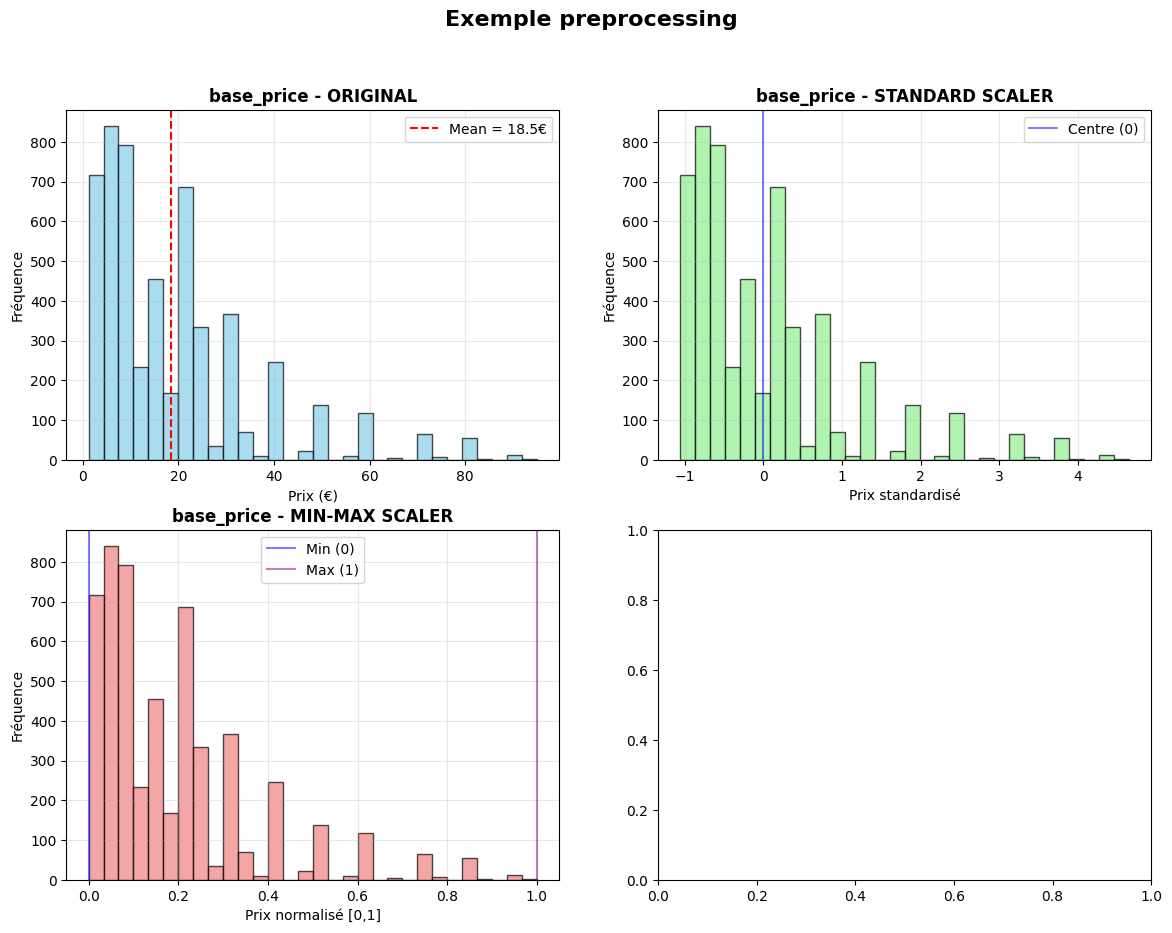

In [776]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Exemple preprocessing', fontsize=16, fontweight='bold')

# Colonne prix réelle
price_col = 'base_price'
if price_col in df_dataset.columns:
    price_data = df_dataset[price_col].dropna()
    
    # Original
    ax = axes[0, 0]
    ax.hist(price_data, bins=30, color='skyblue', edgecolor='black', alpha=0.7)
    ax.set_title(f'{price_col} - ORIGINAL', fontweight='bold')
    ax.set_xlabel('Prix (€)')
    ax.set_ylabel('Fréquence')
    ax.axvline(price_data.mean(), color='red', linestyle='--', label=f'Mean = {price_data.mean():.1f}€')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # StandardScaler
    scaler_std = StandardScaler()
    price_std = scaler_std.fit_transform(price_data.values.reshape(-1, 1))
    
    ax = axes[0, 1]
    ax.hist(price_std, bins=30, color='lightgreen', edgecolor='black', alpha=0.7)
    ax.set_title(f'{price_col} - STANDARD SCALER', fontweight='bold')
    ax.set_xlabel('Prix standardisé')
    ax.set_ylabel('Fréquence')
    ax.axvline(0, color='blue', linestyle='-', alpha=0.5, label='Centre (0)')
    ax.legend()
    ax.grid(alpha=0.3)
    
    # MinMaxScaler
    scaler_mm = MinMaxScaler()
    price_mm = scaler_mm.fit_transform(price_data.values.reshape(-1, 1))
    
    ax = axes[1, 0]
    ax.hist(price_mm, bins=30, color='lightcoral', edgecolor='black', alpha=0.7)
    ax.set_title(f'{price_col} - MIN-MAX SCALER', fontweight='bold')
    ax.set_xlabel('Prix normalisé [0,1]')
    ax.set_ylabel('Fréquence')
    ax.axvline(0, color='blue', linestyle='-', alpha=0.5, label='Min (0)')
    ax.axvline(1, color='purple', linestyle='-', alpha=0.5, label='Max (1)')
    ax.legend()
    ax.grid(alpha=0.3)

## Bibliothèque de modèles pour la classification

In [777]:
def get_classification_models(n_classes=6):
    
    classification_models = {
        
        # ====================================================================
        # MODÈLES LINÉAIRES (Rapides, interprétables)
        # ====================================================================
        "linear": [
            # --- Logistic Regression ---
            {
                "name": "Logistic Regression",
                "category": "linear",
                "model": LogisticRegression(
                    multi_class='multinomial',
                    solver='lbfgs',
                    max_iter=1000,
                    random_state=42,
                    n_jobs=-1
                ),
                "description": "Régression logistique multiclasse",
                "pros": "Simple, rapide, interprétable, probabilités",
                "cons": "Seulement relations linéaires",
                "best_for": "Baseline, interprétabilité",
                "hyperparams": {
                    "C": [0.01, 0.1, 1.0, 10.0],
                    "penalty": ['l2'],
                    "solver": ['lbfgs', 'saga']
                },
            },
            
            # --- Ridge Classifier ---
            {
                "name": "Ridge Classifier",
                "category": "linear",
                "model": RidgeClassifier(alpha=1.0, random_state=42),
                "description": "Classification avec régularisation L2",
                "pros": "Rapide, robuste à la multicolinéarité",
                "cons": "Pas de probabilités",
                "best_for": "Baseline rapide, features corrélées",
                "hyperparams": {
                    "alpha": [0.1, 1.0, 10.0, 100.0]
                },
            },
            
            # --- SGD Classifier ---
            {
                "name": "SGD Classifier",
                "category": "linear",
                "model": SGDClassifier(
                    loss='log_loss',
                    penalty='l2',
                    alpha=0.0001,
                    max_iter=1000,
                    random_state=42,
                    n_jobs=-1
                ),
                "description": "Classification par descente de gradient stochastique",
                "pros": "Très rapide, gros datasets",
                "cons": "Sensible au scaling",
                "best_for": "Très gros datasets",
                "hyperparams": {
                    "alpha": [0.0001, 0.001, 0.01],
                    "penalty": ['l2', 'l1', 'elasticnet']
                },
            },
            
            # --- Linear Discriminant Analysis ---
            {
                "name": "LDA",
                "category": "linear",
                "model": LinearDiscriminantAnalysis(),
                "description": "Analyse discriminante linéaire",
                "pros": "Réduit dimensionnalité, interprétable",
                "cons": "Assume distributions gaussiennes",
                "best_for": "Features corrélées, réduction dimensionnalité",
            },
            
            # --- Quadratic Discriminant Analysis ---
            {
                "name": "QDA",
                "category": "linear",
                "model": QuadraticDiscriminantAnalysis(),
                "description": "Analyse discriminante quadratique",
                "pros": "Gère frontières non-linéaires",
                "cons": "Plus de paramètres que LDA",
                "best_for": "Frontières de décision courbes",
            },
        ],
        
        # ====================================================================
        # MODÈLES À BASE D'ARBRES (Performants, robustes)
        # ====================================================================
        "tree": [
            # --- Decision Tree ---
            {
                "name": "Decision Tree",
                "category": "tree",
                "model": DecisionTreeClassifier(
                    max_depth=10,
                    min_samples_split=10,
                    min_samples_leaf=5,
                    class_weight='balanced',
                    random_state=42
                ),
                "description": "Arbre de décision simple",
                "pros": "Interprétable, gère non-linéarités",
                "cons": "Overfitting facile",
                "best_for": "Baseline arbre, interprétabilité",
                "hyperparams": {
                    "max_depth": [5, 10, 15, 20, None],
                    "min_samples_split": [2, 5, 10, 20],
                    "min_samples_leaf": [1, 2, 5, 10],
                },
            },
            
            # --- Random Forest ---
            {
                "name": "Random Forest",
                "category": "tree",
                "model": RandomForestClassifier(
                    n_estimators=200,
                    max_depth=15,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    max_features='sqrt',
                    class_weight='balanced',  # ⭐ Important
                    random_state=42,
                    n_jobs=-1,
                ),
                "description": "Ensemble d'arbres de décision",
                "pros": "Très performant, robuste, gère déséquilibre",
                "cons": "Moins interprétable",
                "best_for": "Performance générale, RECOMMANDÉ ⭐⭐⭐",
                "hyperparams": {
                    "n_estimators": [100, 200, 300, 500],
                    "max_depth": [10, 15, 20, 25, None],
                    "min_samples_split": [2, 5, 10],
                    "min_samples_leaf": [1, 2, 4],
                    "max_features": ['sqrt', 'log2'],
                },
            },
            
            # --- Extra Trees ---
            {
                "name": "Extra Trees",
                "category": "tree",
                "model": ExtraTreesClassifier(
                    n_estimators=200,
                    max_depth=15,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1,
                ),
                "description": "Random Forest avec splits aléatoires",
                "pros": "Plus rapide que RF, réduit variance",
                "cons": "Peut avoir plus de biais",
                "best_for": "Alternative à RF, plus rapide",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "max_depth": [10, 15, 20, None],
                    "min_samples_split": [2, 5, 10],
                },
            },
            
            # --- Gradient Boosting ---
            {
                "name": "Gradient Boosting",
                "category": "tree",
                "model": GradientBoostingClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=5,
                    min_samples_split=5,
                    min_samples_leaf=2,
                    subsample=0.8,
                    random_state=42,
                ),
                "description": "Boosting séquentiel d'arbres",
                "pros": "Très performant, gère bien les interactions",
                "cons": "Lent à entraîner, pas de class_weight",
                "best_for": "Performance maximale",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1, 0.2],
                    "max_depth": [3, 5, 7],
                    "subsample": [0.7, 0.8, 0.9, 1.0],
                },
            },
            
            # --- Histogram Gradient Boosting ---
            {
                "name": "Hist Gradient Boosting",
                "category": "tree",
                "model": HistGradientBoostingClassifier(
                    max_iter=200,
                    learning_rate=0.1,
                    max_depth=10,
                    min_samples_leaf=20,
                    random_state=42,
                ),
                "description": "Gradient Boosting optimisé (bins)",
                "pros": "Beaucoup plus rapide que GB classique",
                "cons": "Moins précis pour petits datasets",
                "best_for": "Gros datasets, rapidité",
                "hyperparams": {
                    "max_iter": [100, 200, 300],
                    "learning_rate": [0.05, 0.1, 0.2],
                    "max_depth": [5, 10, 15, None],
                },
            },
            
            # --- AdaBoost ---
            {
                "name": "AdaBoost",
                "category": "tree",
                "model": AdaBoostClassifier(
                    estimator=DecisionTreeClassifier(max_depth=5),
                    n_estimators=100,
                    learning_rate=1.0,
                    random_state=42,
                ),
                "description": "Boosting adaptatif",
                "pros": "Simple, adapte aux erreurs",
                "cons": "Sensible au bruit",
                "best_for": "Alternative au Gradient Boosting",
                "hyperparams": {
                    "n_estimators": [50, 100, 200],
                    "learning_rate": [0.5, 1.0, 1.5],
                },
            },
            
            # --- Bagging ---
            {
                "name": "Bagging",
                "category": "tree",
                "model": BaggingClassifier(
                    estimator=DecisionTreeClassifier(max_depth=10),
                    n_estimators=100,
                    max_samples=0.8,
                    max_features=0.8,
                    random_state=42,
                    n_jobs=-1,
                ),
                "description": "Bootstrap Aggregating",
                "pros": "Réduit variance, parallélisable",
                "cons": "Moins performant que RF",
                "best_for": "Baseline ensemble",
            },
            {
                "name": "XGBoost",
                "category": "tree",
                "model": XGBClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=6,
                    min_child_weight=1,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    gamma=0,
                    objective='multi:softmax',
                    num_class=n_classes,
                    random_state=42,
                    n_jobs=-1
                ),
                "description": "Extreme Gradient Boosting",
                "pros": "État de l'art, très performant, rapide",
                "cons": "Beaucoup d'hyperparamètres",
                "best_for": "Performance maximale, compétitions ⭐⭐⭐",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "max_depth": [3, 5, 7, 9],
                    "min_child_weight": [1, 3, 5],
                    "subsample": [0.7, 0.8, 0.9],
                    "colsample_bytree": [0.7, 0.8, 0.9],
                },
            },
    
            # LightGBM
            {
                "name": "LightGBM",
                "category": "tree",
                "model": LGBMClassifier(
                    n_estimators=200,
                    learning_rate=0.1,
                    max_depth=10,
                    num_leaves=31,
                    min_child_samples=20,
                    subsample=0.8,
                    colsample_bytree=0.8,
                    class_weight='balanced',
                    random_state=42,
                    n_jobs=-1,
                    verbose=-1
                ),
                "description": "Light Gradient Boosting Machine",
                "pros": "Très rapide, gère grandes données",
                "cons": "Peut overfit sur petits datasets",
                "best_for": "Gros datasets, rapidité ⭐⭐",
                "hyperparams": {
                    "n_estimators": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "max_depth": [5, 10, 15, -1],
                    "num_leaves": [15, 31, 63],
                    "min_child_samples": [10, 20, 30],
                },
            },
            # CatBoost
            {
                "name": "CatBoost",
                "category": "tree",
                "model": CatBoostClassifier(
                    iterations=200,
                    learning_rate=0.1,
                    depth=6,
                    l2_leaf_reg=3,
                    class_weights=[1] * n_classes,  # Équilibrer
                    random_state=42,
                    verbose=False
                ),
                "description": "Categorical Boosting",
                "pros": "Gère catégorielles nativement, robuste",
                "cons": "Peut être lent",
                "best_for": "Beaucoup de features catégorielles ⭐⭐",
                "hyperparams": {
                    "iterations": [100, 200, 300],
                    "learning_rate": [0.01, 0.05, 0.1],
                    "depth": [4, 6, 8, 10],
                    "l2_leaf_reg": [1, 3, 5, 7],
                },
            }
        ],
        
        # ====================================================================
        # SVM (Support Vector Machines)
        # ====================================================================
        "svm": [
            # --- SVC RBF ---
            {
                "name": "SVC (RBF)",
                "category": "svm",
                "model": SVC(
                    kernel='rbf',
                    C=1.0,
                    gamma='scale',
                    class_weight='balanced',
                    random_state=42
                ),
                "description": "SVM avec noyau radial",
                "pros": "Gère non-linéarités, robuste",
                "cons": "Très lent, difficile à tuner",
                "best_for": "Petits datasets avec patterns complexes",
                "hyperparams": {
                    "C": [0.1, 1.0, 10.0, 100.0],
                    "gamma": ['scale', 'auto', 0.001, 0.01, 0.1],
                },
            },
            
            # --- Linear SVC ---
            {
                "name": "Linear SVC",
                "category": "svm",
                "model": LinearSVC(
                    C=1.0,
                    class_weight='balanced',
                    max_iter=10000,
                    random_state=42
                ),
                "description": "SVM linéaire",
                "pros": "Plus rapide que RBF",
                "cons": "Seulement relations linéaires",
                "best_for": "Alternative linéaire rapide",
                "hyperparams": {
                    "C": [0.1, 1.0, 10.0]
                },
            },
            
            # --- SVC Polynomial ---
            {
                "name": "SVC (Poly)",
                "category": "svm",
                "model": SVC(
                    kernel='poly',
                    degree=3,
                    C=1.0,
                    class_weight='balanced',
                    random_state=42
                ),
                "description": "SVM avec noyau polynomial",
                "pros": "Gère interactions polynomiales",
                "cons": "Très lent, difficile à tuner",
                "best_for": "Interactions polynomiales",
                "hyperparams": {
                    "degree": [2, 3, 4],
                    "C": [0.1, 1.0, 10.0]
                },
            },
        ],
        
        # ====================================================================
        # K-NEAREST NEIGHBORS
        # ====================================================================
        "neighbors": [
            {
                "name": "K-Nearest Neighbors",
                "category": "neighbors",
                "model": KNeighborsClassifier(
                    n_neighbors=5,
                    weights='distance',
                    algorithm='auto',
                    n_jobs=-1
                ),
                "description": "Classification basée sur k plus proches voisins",
                "pros": "Simple, sans apprentissage",
                "cons": "Lent en prédiction, sensible au scaling",
                "best_for": "Patterns locaux, baseline",
                "hyperparams": {
                    "n_neighbors": [3, 5, 10, 15, 20],
                    "weights": ['uniform', 'distance'],
                    "p": [1, 2]  # Manhattan vs Euclidean
                },
            },
        ],
    }
    
    return classification_models


def get_all_models(n_classes=6):
    """Retourne une liste plate de tous les modèles"""
    models_dict = get_classification_models(n_classes)
    all_models = []
    for category, models in models_dict.items():
        all_models.extend(models)
    return all_models


def get_models_by_category(category, n_classes=6):
    """Retourne les modèles d'une catégorie"""
    models_dict = get_classification_models(n_classes)
    return models_dict.get(category, [])


def get_model_by_name(name, n_classes=6):
    """Retourne un modèle par son nom"""
    models_dict = get_classification_models(n_classes)
    for models in models_dict.values():
        for model_dict in models:
            if model_dict["name"] == name:
                return model_dict
    return None

In [778]:
def print_models_table(n_classes=2):
    """Affiche un tableau récapitulatif des modèles"""
    import pandas as pd
    
    models_dict = get_classification_models(n_classes)
    
    data = []
    for category, models in models_dict.items():
        for model_dict in models:
            data.append({
                'Catégorie': category.upper(),
                'Modèle': model_dict['name'],
                'Description': model_dict['description'][:50] + '...' if len(model_dict['description']) > 50 else model_dict['description'],
                'GridSearch': '✅' if 'hyperparams' in model_dict else '❌',
                'Best For': model_dict['best_for'][:40] + '...' if len(model_dict['best_for']) > 40 else model_dict['best_for']
            })
    
    df = pd.DataFrame(data)
    
    print("=" * 120)
    print(f"MODÈLES DE CLASSIFICATION ({n_classes} classes)")
    print("=" * 120)
    print(df.to_string(index=False))
    print(f"\nTOTAL : {len(df)} modèles")
    print("=" * 120)


# Utilisation
print_models_table(n_classes=2)

MODÈLES DE CLASSIFICATION (2 classes)
Catégorie                 Modèle                                           Description GridSearch                                    Best For
   LINEAR    Logistic Regression                     Régression logistique multiclasse          ✅                  Baseline, interprétabilité
   LINEAR       Ridge Classifier                 Classification avec régularisation L2          ✅         Baseline rapide, features corrélées
   LINEAR         SGD Classifier Classification par descente de gradient stochastiq...          ✅                          Très gros datasets
   LINEAR                    LDA                        Analyse discriminante linéaire          ❌ Features corrélées, réduction dimensionn...
   LINEAR                    QDA                     Analyse discriminante quadratique          ❌              Frontières de décision courbes
     TREE          Decision Tree                              Arbre de décision simple          ✅            B

## Premier Tests sur classification binaire 50% réduction avant 1 an

In [779]:
df_binary_disc = df_dataset.copy()

In [780]:
# has_33_percent_discount_before_0.6_year
# has_50_percent_discount_before_1_year
# has_75_percent_discount_before_3_year

TARGET_PROMO_BINNARY_COL = 'has_50_percent_discount_before_1_year'
FEATURES_TO_USE = base_features_post_release

### Nettoyage des données qui ne possèdent pas la target (None)

In [781]:
# On supprime les lignes (jeux récent n'ayant jamais ateind la promotion)
df_binary_disc = df_binary_disc.dropna(subset=[TARGET_PROMO_BINNARY_COL])

print(df_binary_disc[TARGET_PROMO_BINNARY_COL].value_counts())

print(f"Avant: {len(df_dataset)} lignes")
print(f"Après: {len(df_binary_disc)} lignes")

has_50_percent_discount_before_1_year
1.0    2245
0.0    1885
Name: count, dtype: int64
Avant: 5382 lignes
Après: 4130 lignes


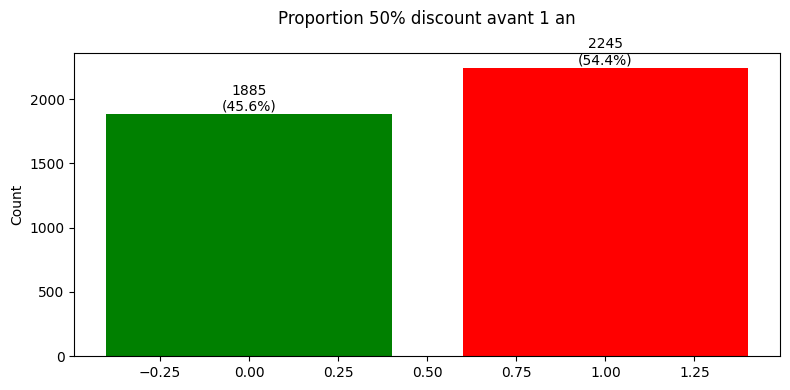

In [782]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))

counts = df_binary_disc[TARGET_PROMO_BINNARY_COL].value_counts()
ax : plt.Axes
bars = ax.bar(counts.index, counts.values, color=['red', 'green'])
ax.set_title('Proportion 50% discount avant 1 an\n')
ax.set_ylabel('Count')

# Ajouter pourcentages
for bar in bars:
    height = bar.get_height()
    pct = height / len(df_binary_disc[TARGET_PROMO_BINNARY_COL]) * 100
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}\n({pct:.1f}%)',
            ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Chargement des features de base

In [783]:
base_X_features = get_all_features_columns(FEATURES_TO_USE)

# Sélectionner les colonnes disponibles
X = df_binary_disc[base_X_features]

# On assigne la target
y = df_binary_disc[TARGET_PROMO_BINNARY_COL]

### Création train test split

In [784]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

print(f"\nTrain : {len(X_train)} | Test : {len(X_test)}")
print("\nDistribution classes (train) :")


Train : 3304 | Test : 826

Distribution classes (train) :


### Preprocess

In [785]:
pipelines, X_train_dict, X_test_dict = create_pipelines(X_train, X_test,available_columns=FEATURES_TO_USE)

for t, pipeline in pipelines.items():
    print(f"\n{t.upper()} Train processed : {X_train_dict[t].shape}")
    print(f"{t.upper()} Test processed  : {X_test_dict[t].shape}")


Pipeline TREE créé avec 6 groupes de transformers
Pipeline LINEAR créé avec 6 groupes de transformers
Pipeline SVM créé avec 6 groupes de transformers

TREE Train processed : (3304, 33)
TREE Test processed  : (826, 33)

LINEAR Train processed : (3304, 35)
LINEAR Test processed  : (826, 35)

SVM Train processed : (3304, 35)
SVM Test processed  : (826, 35)


In [786]:
pipelines['tree']

,steps,"[('preprocessor', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num_continuous', ...), ('num_discrete_zero', ...), ...]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,False


### Optimisation des hyper paramétres pour Random Forest

In [787]:
# Définition du modèle de base
model = RandomForestClassifier(random_state=42,class_weight='balanced')
# Définition des hyperparamètres à tester

# OVERFITTING max depth None.

# param_grid = {
#     'n_estimators': [50, 100, 200],
#     'max_depth': [None, 10, 20, 30],
#     'min_samples_split': [2, 5],
#     'min_samples_leaf': [1, 2, 4]
# }

param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [8, 10, 12],
    'min_samples_split': [10, 20],
    'min_samples_leaf': [5, 10]
}

# Configuration de la validation croisée
cv_strategy = StratifiedKFold(n_splits=5, shuffle=True, random_state=42) # 5-fold cross-validation
# Grille de recherche
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, 
                           scoring='accuracy', cv=cv_strategy, n_jobs=-1, verbose=2)

# Entraînement du modèle avec GridSearch
grid_search.fit(X_train_dict['tree'], y_train)

# Meilleurs hyperparamètres
print("\nMeilleurs hyperparamètres trouvés:")
print(grid_search.best_params_)

# Meilleur score
print(f"Meilleur score de validation: {grid_search.best_score_:.2%}")
# Entraînement du modèle avec les meilleurs hyperparamètres
best_model = grid_search.best_estimator_

Fitting 5 folds for each of 24 candidates, totalling 120 fits
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=10, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.5s
[CV] END max_depth=8, min_samples_leaf=5, min_samples_split=20, n_estimators=200; total time=   0.4s
[CV] END max_depth=8, min_sam

### Cross-validation Random forest

In [788]:
# Récupérer les scores CV du GridSearch
cv_scores = grid_search.cv_results_['mean_test_score']

best_cv_score = grid_search.best_score_

print(f"Meilleur score CV: {best_cv_score:.4f}")
print(f"Scores CV: {cv_scores}")
print(f"Score CV moyen: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

Meilleur score CV: 0.6825
Scores CV: [0.67554302 0.67524275 0.67675652 0.67917847 0.66979508 0.67342686
 0.66979508 0.67342686 0.67493834 0.67735983 0.6785692  0.6764512
 0.67463485 0.6758456  0.67463485 0.6758456  0.6788704  0.6825008
 0.67523954 0.68129235 0.67493651 0.67947829 0.67493651 0.67947829]
Score CV moyen: 0.6762 (+/- 0.0061)


### Prédictions

In [789]:
y_pred_train = best_model.predict(X_train_dict['tree'])
y_pred_test = best_model.predict(X_test_dict['tree'])

### Evaluation

- cv-score
- precision    
- recall  
- f1-score

In [790]:
train_accuracy = accuracy_score(y_train, y_pred_train)
test_accuracy = accuracy_score(y_test, y_pred_test)

print(f"Train: {train_accuracy:.4f}")
print(f"Test: {test_accuracy:.4f}")

# Rapport de classification détaillé
print("\nRapport de classification (Test):")
print(classification_report(y_test, y_pred_test))

# Matrice de confusion
print("\nMatrice de confusion:")
cm = confusion_matrix(y_test, y_pred_test)
print(cm)

Train: 0.8547
Test: 0.7058

Rapport de classification (Test):
              precision    recall  f1-score   support

         0.0       0.68      0.68      0.68       377
         1.0       0.73      0.73      0.73       449

    accuracy                           0.71       826
   macro avg       0.70      0.70      0.70       826
weighted avg       0.71      0.71      0.71       826


Matrice de confusion:
[[257 120]
 [123 326]]


### Visualisation des résultats

In [791]:
def plot_classification_results(model, y_train, y_test,y_train_pred, y_test_pred, 
                                cv_scores, feature_names=None):
    """
    Crée une figure avec 4 graphiques de résultats
    
    Parameters:
    -----------
    model : fitted model
        Modèle entraîné
    X_train, X_test : arrays
        Données train/test
    y_train, y_test : arrays
        Labels train/test
    cv_scores : array
        Scores de cross-validation
    feature_names : list, optional
        Noms des features
    """
    
    # Scores
    train_acc = (y_train_pred == y_train).mean()  # ✅ Correction
    test_acc = (y_test_pred == y_test).mean()
    
    # Créer figure
    fig = plt.figure(figsize=(16, 12))
    gs = fig.add_gridspec(2, 2, hspace=0.3, wspace=0.3)
    
    # ========================================================================
    # MATRICE DE CONFUSION
    # ========================================================================
    ax1 = fig.add_subplot(gs[0, 0])
    
    cm = confusion_matrix(y_test, y_test_pred)
    
    # Heatmap
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                cbar_kws={'label': 'Count'},
                ax=ax1, square=True, linewidths=1, linecolor='black')
    
    ax1.set_title('MATRICE DE CONFUSION (Test)', fontweight='bold', fontsize=14)
    ax1.set_xlabel('Prédiction', fontweight='bold')
    ax1.set_ylabel('Réel', fontweight='bold')
    
    # Ajouter pourcentages
    total = cm.sum()
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            pct = cm[i, j] / cm[i].sum() * 100
            ax1.text(j + 0.5, i + 0.7, f'({pct:.1f}%)', 
                    ha='center', va='center', fontsize=10, color='gray')
    
    # ========================================================================
    # ACCURACY TRAIN VS TEST
    # ========================================================================
    ax2 = fig.add_subplot(gs[0, 1])
    
    categories = ['Train', 'Test']
    accuracies = [train_acc, test_acc]
    colors = ['lightgreen', 'lightcoral' if train_acc - test_acc > 0.1 else 'lightblue']
    
    bars = ax2.bar(categories, accuracies, color=colors, edgecolor='black', linewidth=2)
    
    # Ajouter valeurs
    for i, (cat, acc) in enumerate(zip(categories, accuracies)):
        ax2.text(i, acc + 0.02, f'{acc:.2%}', 
                ha='center', va='bottom', fontweight='bold', fontsize=12)
    
    ax2.set_ylim(0, 1.1)
    ax2.set_ylabel('Accuracy', fontweight='bold')
    ax2.set_title('ACCURACY TRAIN vs TEST', fontweight='bold', fontsize=14)
    ax2.grid(axis='y', alpha=0.3)
    ax2.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Baseline (50%)')
    
    # Overfitting warning
    overfitting_gap = train_acc - test_acc
    if overfitting_gap > 0.2:
        ax2.text(0.5, 0.95, f'⚠️ OVERFITTING\nÉcart: {overfitting_gap:.1%}',
                transform=ax2.transAxes, ha='center', va='top',
                bbox=dict(boxstyle='round', facecolor='yellow', alpha=0.7),
                fontweight='bold', fontsize=10)
    
    ax2.legend()
    
    # ========================================================================
    # CROSS-VALIDATION SCORES
    # ========================================================================
    ax3 = fig.add_subplot(gs[1, 0])
    
    folds = np.arange(1, len(cv_scores) + 1)
    mean_cv = cv_scores.mean()
    std_cv = cv_scores.std()
    
    # Barplot des scores CV
    bars = ax3.bar(folds, cv_scores, color='steelblue', edgecolor='black', 
                   alpha=0.7, label='Score par fold')
    
    # Ligne moyenne
    ax3.axhline(y=mean_cv, color='red', linestyle='--', linewidth=2, 
               label=f'Moyenne: {mean_cv:.2%}')
    
    # Zone de confiance (±2 std)
    ax3.axhspan(mean_cv - 2*std_cv, mean_cv + 2*std_cv, 
               alpha=0.2, color='red', label=f'±2σ ({2*std_cv:.2%})')
    
    # Ajouter valeurs
    for i, (fold, score) in enumerate(zip(folds, cv_scores)):
        ax3.text(fold, score + 0.01, f'{score:.3f}', 
                ha='center', va='bottom', fontsize=9)
    
    ax3.set_xlabel('Fold', fontweight='bold')
    ax3.set_ylabel('Accuracy', fontweight='bold')
    ax3.set_title(f'CROSS-VALIDATION (5-Fold)\nMoyenne: {mean_cv:.2%} ± {std_cv:.2%}', 
                 fontweight='bold', fontsize=14)
    ax3.set_xticks(folds)
    ax3.set_ylim(0, 1.1)
    ax3.grid(axis='y', alpha=0.3)
    ax3.legend(loc='lower right')
    
    # ========================================================================
    # FEATURE IMPORTANCE
    # ========================================================================
    ax4 = fig.add_subplot(gs[1, 1])
    
    # Récupérer importance
    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        
        # Si pas de feature_names, utiliser indices
        if feature_names is None:
            feature_names = [f'Feature {i}' for i in range(len(importances))]
        
        # Trier par importance
        indices = np.argsort(importances)[::-1]
        
        # Top 15 features
        top_n = min(15, len(importances))
        top_indices = indices[:top_n]
        top_importances = importances[top_indices]
        top_names = [feature_names[i] for i in top_indices]
        
        # Horizontal barplot
        y_pos = np.arange(len(top_names))
        bars = ax4.barh(y_pos, top_importances, color='mediumseagreen', 
                       edgecolor='black', alpha=0.7)
        
        # Ajouter valeurs
        for i, (name, imp) in enumerate(zip(top_names, top_importances)):
            ax4.text(imp + 0.001, i, f'{imp:.4f}', 
                    va='center', fontsize=9)
        
        ax4.set_yticks(y_pos)
        ax4.set_yticklabels(top_names, fontsize=9)
        ax4.set_xlabel('Importance', fontweight='bold')
        ax4.set_title(f'FEATURE IMPORTANCE (Top {top_n})', 
                     fontweight='bold', fontsize=14)
        ax4.grid(axis='x', alpha=0.3)
        ax4.invert_yaxis()
        
    else:
        ax4.text(0.5, 0.5, 'Feature Importance\nnon disponible\npour ce modèle',
                ha='center', va='center', fontsize=14,
                transform=ax4.transAxes,
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
        ax4.set_title('FEATURE IMPORTANCE', fontweight='bold', fontsize=14)
        ax4.axis('off')
    
    fig.suptitle(f'RÉSULTATS DE CLASSIFICATION - {type(model).__name__}', 
                fontsize=18, fontweight='bold', y=0.98)
    
    return fig


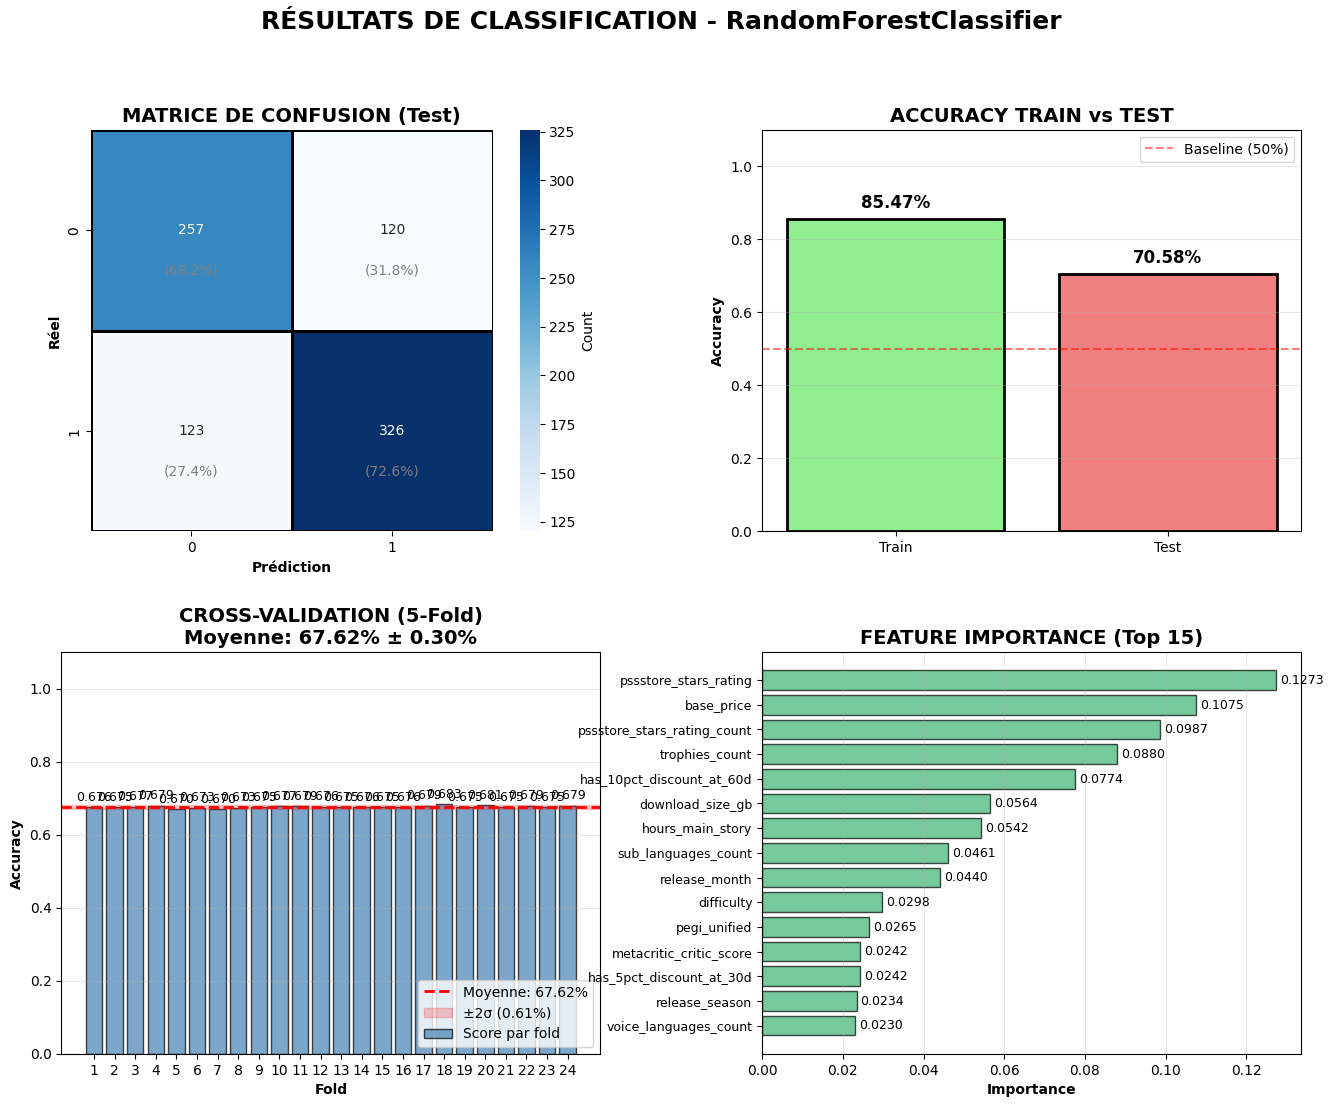

In [792]:
preprocessor = pipelines['tree']
feature_names = list(preprocessor.get_feature_names_out())

fig = plot_classification_results(
    model=best_model,
    y_train= y_train,
    y_test=y_test,
    y_train_pred = y_pred_train,
    y_test_pred = y_pred_test,
    cv_scores=cv_scores,
    feature_names=feature_names
)

### Tests avec les autres modèles de classification

## Premier tests de prédictions Classification multiple

In [793]:
df_clean = df_dataset.copy()

### Choisir la target: niveau de promotion

In [794]:
TARGET_PROMO_COL = 'days_to_50_percent_discount_category'
FEATURES_TO_USE = all_features_post_release
RECENT_GAMES_NO_DISCOUNT_CAT = 'moins_de_2_ans_sans_baisse'

### Nettoyage des données qui ne possèdent pas la target

In [795]:
# On supprime les lignes (jeux récent n'ayant jamais ateind la promotion)
df_clean = df_clean[df_clean[TARGET_PROMO_COL] != RECENT_GAMES_NO_DISCOUNT_CAT]

print(df_clean[TARGET_PROMO_COL].value_counts())

print(f"Avant: {len(df_dataset)} lignes")
print(f"Après: {len(df_clean)} lignes")

days_to_50_percent_discount_category
6-12_mois         1216
1-2_ans            702
3-6_mois           592
jamais_ou_plus     576
0-3_mois           449
Name: count, dtype: int64
Avant: 5382 lignes
Après: 3535 lignes


### Récupération des features de base

In [796]:
base_X_features = get_all_features_columns(FEATURES_TO_USE)

# Sélectionner colonnes disponibles
X = df_clean[base_X_features]

# On assigne la target
y = df_clean[TARGET_PROMO_COL]

### Vérification des colonnes 

In [797]:
column_summary(X)

Résumé détaillé des colonnes:
                      Column    Type  Non-Null Count  Null Count  Unique Values
                  base_price float64            3535           0             61
       pssstore_stars_rating float64            3535           0            318
     metacritic_critic_score float64             949        2586             65
            hours_main_story float64            2463        1072             85
            download_size_gb float64            1875        1660            784
          packs_deluxe_count   int64            3535           0              9
                series_count   int64            3535           0             24
         sub_languages_count float64            2539         996             31
       voice_languages_count float64            1707        1828             17
        publisher_game_count   int64            3535           0             52
                  dlcs_count   int64            3535           0             54
          

### Création train test split

In [798]:
# Encoder les catégories en nombres
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.2, 
    random_state=42,
    stratify=y  
)

print(f"\nTrain : {len(X_train)} | Test : {len(X_test)}")
print("\nDistribution classes (train) :")


Train : 2828 | Test : 707

Distribution classes (train) :


### Creation des pipelines preprocess

In [799]:
pipelines, X_train_dict, X_test_dict = create_pipelines(X_train, X_test,available_columns=FEATURES_TO_USE)

for t, pipeline in pipelines.items():
    print(f"\n{t.upper()} Train processed : {X_train_dict[t].shape}")
    print(f"{t.upper()} Test processed  : {X_test_dict[t].shape}")

Pipeline TREE créé avec 7 groupes de transformers
Pipeline LINEAR créé avec 7 groupes de transformers
Pipeline SVM créé avec 7 groupes de transformers

TREE Train processed : (2828, 46)
TREE Test processed  : (707, 46)

LINEAR Train processed : (2828, 74)
LINEAR Test processed  : (707, 74)

SVM Train processed : (2828, 74)
SVM Test processed  : (707, 74)


### Random forest Classifier

In [800]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# Modèle
rf_clf = RandomForestClassifier(
    n_estimators=500,
    max_depth=15,
    min_samples_split=5,
    class_weight='balanced',  # pour classes déséquilibrées
    random_state=42,
    n_jobs=-1
)

# Entraîner
rf_clf.fit(X_train_dict['tree'], y_train)

# Prédire
predictions = rf_clf.predict(X_test_dict['tree'])

# Évaluer
print(f"Accuracy : {accuracy_score(y_test, predictions):.3f}")
print("\n" + classification_report(y_test, predictions))

Accuracy : 0.477

              precision    recall  f1-score   support

           0       0.53      0.53      0.53        90
           1       0.33      0.44      0.38       141
           2       0.44      0.23      0.30       118
           3       0.53      0.60      0.56       243
           4       0.60      0.46      0.52       115

    accuracy                           0.48       707
   macro avg       0.48      0.45      0.46       707
weighted avg       0.49      0.48      0.47       707



In [801]:
from xgboost import XGBClassifier

# Modèle
xgb_clf = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    objective='multi:softmax',  # ⭐ Classification multiclasse
    num_class=6,                # ⭐ 6 catégories
    random_state=42,
    n_jobs=-1
)

# Entraîner
xgb_clf.fit(X_train_dict['tree'], y_train)

# Prédire
predictions = xgb_clf.predict(X_test_dict['tree'])

# Évaluer
print(f"Accuracy : {accuracy_score(y_test, predictions):.3f}")
print("\n" + classification_report(y_test, predictions))

Accuracy : 0.461

              precision    recall  f1-score   support

           0       0.59      0.43      0.50        90
           1       0.33      0.30      0.32       141
           2       0.36      0.21      0.27       118
           3       0.47      0.67      0.55       243
           4       0.59      0.49      0.53       115

    accuracy                           0.46       707
   macro avg       0.47      0.42      0.43       707
weighted avg       0.46      0.46      0.45       707



### TODO

In [802]:
# KNN amputation

## Automatiser démarche empirique

Création d'un système permettant de lancer une bibliothèque de modèles sur plusieurs combinaisons de features et plusieurs target de prédictions.

### Tests de tous les modèles

In [803]:
def train_all_models(X_train_dict:dict, X_test_dict:dict, y_train, y_test, n_classes=6, use_grid_search=False):
    results = []

    for config in get_all_models(n_classes):
        try:
            # Entraîner
            cat_model = config.get('category', 'N/A') # tree, linear, svm
            
            X_tr = X_train_dict[cat_model]
            X_te = X_test_dict[cat_model]
                
            model = config["model"]
            print(f"Start with {config["name"]}")
   
            # Grille de paramètres - GridSearch
            if "hyperparams" in config and use_grid_search is True:
                grid_search = GridSearchCV(
                    model, config["hyperparams"],
                    cv=5, scoring='neg_mean_absolute_error',
                    n_jobs=-1, verbose=0
                )
                grid_search.fit(X_tr, y_train)
                predictions = grid_search.predict(X_te)
                print(grid_search.best_params_)
            else:
                model.fit(X_tr, y_train)
                predictions = model.predict(X_te)

            # Évaluer
            accuracy = accuracy_score(y_test, predictions)
            report = classification_report(y_test, predictions)
            
            
            results.append({
                'Model': config['name'],
                'Accuracy':accuracy,
                'Report': report,
                'Category': config.get('category', 'N/A')
            })
            
            print(f"✅ {config['name']:30} : Accuracy = {accuracy:.2f}")
            
        except Exception as e:
            print(f"❌ {config['name']:30} : {str(e)[:50]}")

    # Afficher résultats triés
    df_results = pd.DataFrame(results).sort_values('Accuracy',ascending=False)
    print("\n" + df_results.to_string(index=False))

### Vérification de la méthode d'entrainement sur plusieurs modèles

In [804]:
train_all_models(X_train_dict, X_test_dict, y_train, y_test, n_classes=6, use_grid_search=False)

Start with Logistic Regression
✅ Logistic Regression            : Accuracy = 0.43
Start with Ridge Classifier
✅ Ridge Classifier               : Accuracy = 0.45
Start with SGD Classifier
✅ SGD Classifier                 : Accuracy = 0.41
Start with LDA
✅ LDA                            : Accuracy = 0.45
Start with QDA
✅ QDA                            : Accuracy = 0.28
Start with Decision Tree
✅ Decision Tree                  : Accuracy = 0.38
Start with Random Forest
✅ Random Forest                  : Accuracy = 0.47
Start with Extra Trees
✅ Extra Trees                    : Accuracy = 0.46
Start with Gradient Boosting
✅ Gradient Boosting              : Accuracy = 0.46
Start with Hist Gradient Boosting
✅ Hist Gradient Boosting         : Accuracy = 0.45
Start with AdaBoost
✅ AdaBoost                       : Accuracy = 0.40
Start with Bagging
✅ Bagging                        : Accuracy = 0.47
Start with XGBoost
✅ XGBoost                        : Accuracy = 0.46
Start with LightGBM
✅ LightG

Prendre les meilleures modèles et faire des vérifications plus appronfondies (pas de suraprentissage etc.)

In [ ]:
def launch_all_models(df:pd.DataFrame,target_col_to_use,featuresX_to_use):
    df_m = df.copy()

    # On supprime la target des données de test
    df_m = df_m[df_m[target_col_to_use] != RECENT_GAMES_NO_DISCOUNT_CAT]

    base_X_features = get_all_features_columns(featuresX_to_use)

    # Sélectionner colonnes disponibles
    X = df_m[base_X_features]

    # On assigne la target
    y = df_m[target_col_to_use]

    # Encoder la target catégories en nombres
    le = LabelEncoder()
    y = le.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, 
        y, 
        test_size=0.2, 
        random_state=42,
        stratify=y  
    )
    
    pipelines, X_train_dict, X_test_dict = create_pipelines(X_train, X_test,available_columns=featuresX_to_use)

    train_all_models(X_train_dict, X_test_dict, y_train, y_test, n_classes=6, use_grid_search=False)
    


In [806]:
launch_all_models(df_dataset, 'days_to_50_percent_discount_category', all_features_post_release)

Pipeline TREE créé avec 7 groupes de transformers
Pipeline LINEAR créé avec 7 groupes de transformers
Pipeline SVM créé avec 7 groupes de transformers
Start with Logistic Regression
✅ Logistic Regression            : Accuracy = 0.43
Start with Ridge Classifier
✅ Ridge Classifier               : Accuracy = 0.45
Start with SGD Classifier
✅ SGD Classifier                 : Accuracy = 0.41
Start with LDA
✅ LDA                            : Accuracy = 0.45
Start with QDA
✅ QDA                            : Accuracy = 0.28
Start with Decision Tree
✅ Decision Tree                  : Accuracy = 0.38
Start with Random Forest
✅ Random Forest                  : Accuracy = 0.47
Start with Extra Trees
✅ Extra Trees                    : Accuracy = 0.46
Start with Gradient Boosting
✅ Gradient Boosting              : Accuracy = 0.46
Start with Hist Gradient Boosting
✅ Hist Gradient Boosting         : Accuracy = 0.45
Start with AdaBoost
✅ AdaBoost                       : Accuracy = 0.40
Start with Baggin